# Matrix Bubbling

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from matplotlib import colors
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time

## Computing Distances

The `computeDistance` function computes the distance between two matrices `A` and `B` and returns a score. Here, `n` is a parameter that specifies how many cuts to make along each axis.

In [3]:
def computeDistance(A, B, n, metric):
    '''returns a matrix of all the distances for each block'''
    row, col = A.shape
    # trim matrix so grids are all the same size
    row -= row % n
    col -= col % n
    # dist = 0
    dist = np.zeros((row // n, col // n))
    for i in range(row // n):
        for j in range(col // n):
            gridA = A[np.ix_(range(n*i,n*i+n), range(n*j,n*j+n))]
            gridB = B[np.ix_(range(n*i,n*i+n), range(n*j,n*j+n))]
            meanA, covA = getSummary(gridA)
            meanB, covB = getSummary(gridB)
            if meanA != [] and meanB != []:
                # dist += getDist(meanA, covA, meanB, covB, metric)
                blockDist = getDist(meanA, covA, meanB, covB, metric)
                dist[i, j] = 0 if np.isnan(blockDist) else blockDist
            # else:
                # dist += 0 # ignore this grid since nothing is in it
    return dist

def getSummary(grid):
    '''get the mean and covariance of the grid'''
    # get points in grid as an array
    x = []
    y = []
    row, col = grid.shape
    for i in range(row):
        for j in range(col):
            x += [int(i) for x in range(grid[i][j] // 5)]
            y += [int(j) for x in range(grid[i][j] // 5)]
    if x == [] or y == []:
        return ([],[])
    
    x = np.array(x)
    y = np.array(y)
    xMean = np.mean(x)
    yMean = np.mean(y)
    mean = np.array([xMean, yMean])
    x = x - xMean
    y = y - yMean
    coords = np.vstack([x, y])
    cov = np.cov(coords)
    return (mean.T, cov)

def getDist(meanA, covA, meanB, covB, metric):
    '''pick which distance metric to use'''
    if metric == "KL":
        return getKLDiv(meanA, covA, meanB, covB)
    if metric == "Hell":
        return getHellDist(meanA, covA, meanB, covB)
    else:
        raise ValueError()

def getKLDiv(meanA, covA, meanB, covB):
    '''A represents the actual distribution and B represents the baseline distribution'''
    mu = meanB - meanA
    detA = np.linalg.det(covA)
    if detA <= 0: # this makes sure the argument of np.log is greater than 0
        detA = 0.001
    detB = np.linalg.det(covB)
    if detB <= 0:
        detB = 0.001
    log = np.log(detB / detA)
    conj = mu.T @ np.linalg.pinv(covB) @ mu
    trace = np.trace(covA @ np.linalg.pinv(covB))
    return max(0, 0.5 * (log + conj + trace - 2))

def getHellDist(meanA, covA, meanB, covB):
    mu = meanA - meanB
    dist = 1 \
           - np.power(np.linalg.det(covA), 0.25) \
           * np.power(np.linalg.det(covB), 0.25) \
           / np.power(np.linalg.det((covA+covB)/2), 0.5) \
           * np.exp(-0.125 * mu.T @ np.linalg.pinv((covA+covB)/2) @ mu)
    return max(0, dist)

## Test Comparisons

We perform test comparisons between `test1` and `test2` to debug and to see if the output makes sense.

Comparing test1 and test1
Metric: Hell
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
dist: 0.0

Comparing test1 and test2
Metric: Hell
[[0.   0.09 0.02 0.04]
 [0.   0.19 0.22 0.03]
 [0.   0.1  0.04 0.1 ]]
dist: 0.83

Comparing test2 and test1
Metric: Hell
[[0.   0.09 0.02 0.04]
 [0.   0.19 0.22 0.03]
 [0.   0.1  0.04 0.1 ]]
dist: 0.83

Comparing test2 and test2
Metric: Hell
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
dist: 0.0



/Users/Jacky/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:15: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  from ipykernel import kernelapp as app


-----------------------
Comparing test1 and test1
Metric: KL
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
dist: 0.0

Comparing test1 and test2
Metric: KL
[[0.01 0.34 0.09 0.19]
 [0.   0.85 0.94 0.13]
 [0.   0.6  0.16 0.44]]
dist: 3.75

Comparing test2 and test1
Metric: KL
[[0.01 0.43 0.1  0.15]
 [0.   0.88 1.1  0.09]
 [0.   0.3  0.14 0.5 ]]
dist: 3.7

Comparing test2 and test2
Metric: KL
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
dist: 0.0

-----------------------


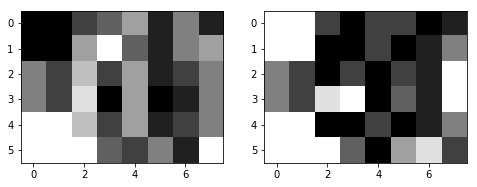

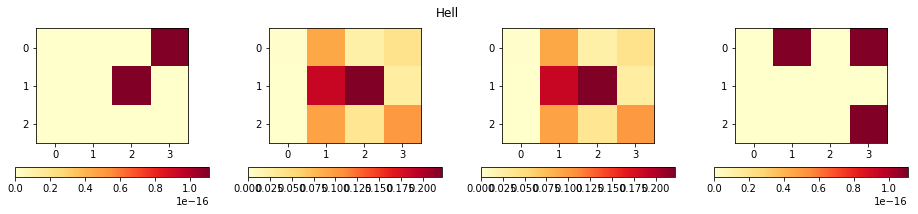

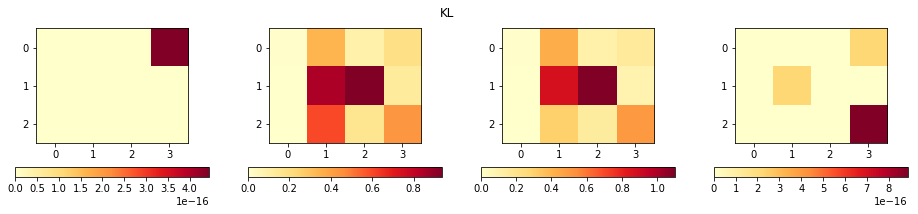

In [4]:
# test matrices
test1 = np.array([[10, 10, 30, 40, 60, 20, 50, 20],
                  [10, 10, 60, 90, 40, 20, 50, 60],
                  [50, 30, 70, 30, 60, 20, 30, 50],
                  [50, 30, 80, 10, 60, 10, 20, 50],
                  [90, 90, 70, 30, 60, 20, 30, 50],
                  [90, 90, 90, 40, 30, 50, 20, 90]])

test2 = np.array([[90, 90, 30, 10, 30, 30, 10, 20],
                  [90, 90, 10, 10, 30, 10, 20, 50],
                  [50, 30, 10, 30, 10, 30, 20, 90],
                  [50, 30, 80, 90, 10, 40, 20, 90],
                  [90, 90, 10, 10, 30, 10, 20, 50],
                  [90, 90, 90, 40, 10, 60, 80, 30]])

f, axarr = plt.subplots(1, 2, figsize=(8, 3))
axarr[0].imshow(test1, cmap="gray")
axarr[1].imshow(test2, cmap="gray")

for metric in ["Hell", "KL"]:
    f, axarr = plt.subplots(1, 4, figsize=(16, 3)) # heatmap
    f.suptitle(metric)
    y = 0
    for (A, B) in [(test1, test1), (test1, test2), (test2, test1), (test2, test2)]:
        a = "test1" if np.array_equal(A, test1) else "test2"
        b = "test1" if np.array_equal(B, test1) else "test2"
        print("Comparing", a, "and", b)
        print("Metric:", metric)
        dist = computeDistance(A, B, 2, metric)
        print(np.around(dist, decimals=2))
        print("dist:", round(np.sum(dist), 2))
        print()
        a = axarr[y].imshow(dist, cmap="YlOrRd")
        f.colorbar(a, ax=axarr[y], orientation='horizontal')
        y += 1
    print("-----------------------")

# Comparing Images

Here we perform comparisons with different images for different purposes.

## Comparing Letters

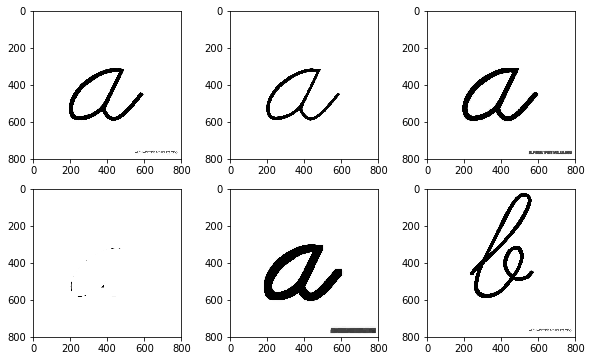

In [5]:
def getTransforms(image):
    '''get transformed versions of image'''
    kernel = np.ones((5, 5), np.uint8)
    dilation = cv2.dilate(image, kernel, iterations = 1)
    erosion = cv2.erode(image, kernel, iterations = 1)
    kernel2 = np.ones((20, 20), np.uint8)
    dilation2 = cv2.dilate(image, kernel2, iterations = 1)
    erosion2 = cv2.erode(image, kernel2, iterations = 1)
    return [dilation, erosion, dilation2, erosion2]

# images for comparisons
base_chars = ["a", "b"]
base_images = [cv2.imread("samples/alphabet_cursive_letter_" + char + ".jpg", 0) for char in base_chars]
compare = [base_images[0]] + getTransforms(base_images[0]) + [base_images[1]]

# plot images
f, axarr = plt.subplots(2, 3, figsize=(10, 6))
for i in range(len(compare)):
    axarr[i // 3, i % 3].imshow(compare[i], cmap="gray")

Here, we compare the letter A and the letter B against tranformed versions of the letter A.

A: Comparison #0
B: The original letter A
Metric: Hell


/Users/Jacky/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:15: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  from ipykernel import kernelapp as app
/Users/Jacky/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Degrees of freedom <= 0 for slice
/usr/local/lib/python3.6/site-packages/numpy/lib/function_base.py:2326: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/site-packages/numpy/lib/function_base.py:2326: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/site-packages/numpy/linalg/linalg.py:2022: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, 

Distance: 1.2212453270876722e-14
Running time: 50.11s

A: Comparison #1
B: The original letter A
Metric: Hell
Distance: 23.240599411242385
Running time: 49.98s

A: Comparison #2
B: The original letter A
Metric: Hell
Distance: 30.651682532962568
Running time: 49.2s

A: Comparison #3
B: The original letter A
Metric: Hell
Distance: 58.51488845062939
Running time: 50.08s

A: Comparison #4
B: The original letter A
Metric: Hell
Distance: 61.360558199413134
Running time: 47.93s

A: Comparison #5
B: The original letter A
Metric: Hell
Distance: 135.35300916972278
Running time: 48.5s

-----------------------
A: Comparison #0
B: The original letter A
Metric: KL
Distance: 2.19824158875781e-14
Running time: 48.37s

A: Comparison #1
B: The original letter A
Metric: KL
Distance: 253.78996499776883
Running time: 50.93s

A: Comparison #2
B: The original letter A
Metric: KL
Distance: 115.89487256216114
Running time: 47.88s

A: Comparison #3
B: The original letter A
Metric: KL
Distance: 2568.992442599855

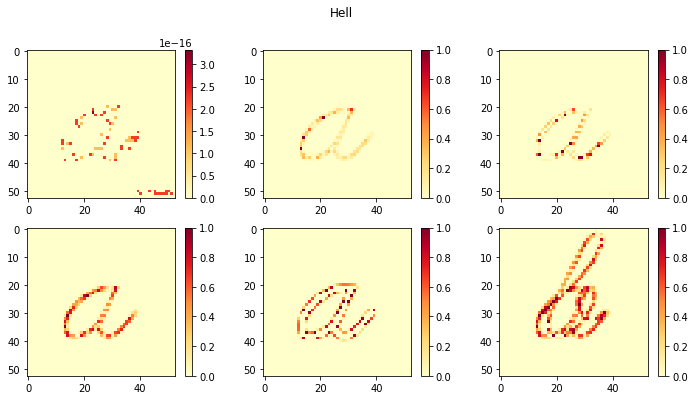

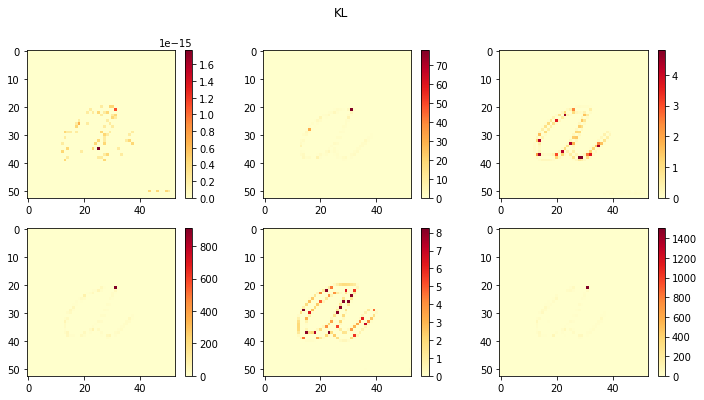

In [6]:
overall_start_time = time.time()
for metric in ["Hell", "KL"]:
    f, axarr = plt.subplots(2, (len(compare) + 1) // 2, figsize=(12, 6))
    f.suptitle(metric)
    for i in range(len(compare)):
            print("A: Comparison #" + str(i))
            print("B:", "The original letter A")
            print("Metric:", str(metric))
            start_time = time.time()
            # dist = np.zeros((5,5)) # debug
            dist = computeDistance(compare[i], compare[0], 15, metric)
            diff_time = round(time.time() - start_time, 2)
            print("Distance:", np.sum(dist))
            print("Running time:", str(diff_time) + "s")
            print()
            a = axarr[i // 3, i % 3].imshow(dist, cmap="YlOrRd")
            f.colorbar(a, ax=axarr[i // 3, i % 3])
    print("-----------------------")
overall_diff_time = time.time() - overall_start_time
print("Total running time: ", str(overall_diff_time // 60) + "min", str(round(overall_diff_time % 60, 2)) + "s")

## Comparing Compressed Images

Here, we compare an image with several compressed versions of itself.

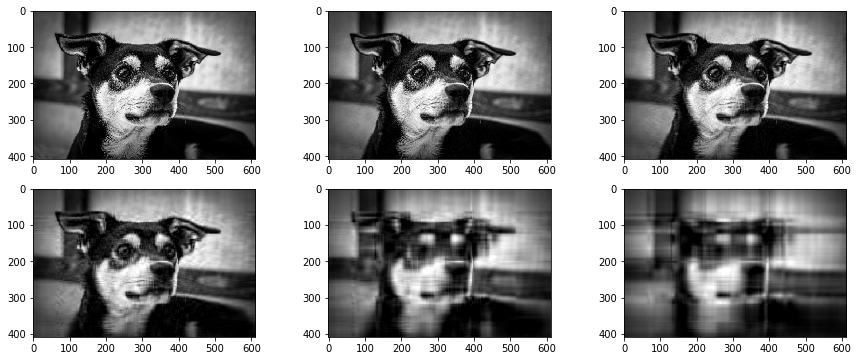

In [7]:
# images for comparisons
original = cv2.imread("samples/original.png", 0)
compressed = [cv2.imread("samples/svd_" + str(svd_val) + ".png", 0) for svd_val in [100, 50, 25, 10, 5]]

# plot images
f, axarr = plt.subplots(2, 3, figsize=(15, 6))
axarr[0, 0].imshow(original, cmap="gray")
axarr[0, 1].imshow(compressed[0], cmap="gray")
axarr[0, 2].imshow(compressed[1], cmap="gray")
axarr[1, 0].imshow(compressed[2], cmap="gray")
axarr[1, 1].imshow(compressed[3], cmap="gray")
axarr[1, 2].imshow(compressed[4], cmap="gray")

Comparing original with compressed image #0
Metric: Hell


/Users/Jacky/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:15: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  from ipykernel import kernelapp as app
/Users/Jacky/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Degrees of freedom <= 0 for slice
/usr/local/lib/python3.6/site-packages/numpy/lib/function_base.py:2326: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/site-packages/numpy/lib/function_base.py:2326: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/site-packages/numpy/linalg/linalg.py:2022: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, 

Distance: 18.085822727368566
Running time: 10.63s

Comparing original with compressed image #1
Metric: Hell
Distance: 17.596173968166088
Running time: 11.26s

Comparing original with compressed image #2
Metric: Hell
Distance: 25.32751693420247
Running time: 10.59s

Comparing original with compressed image #3
Metric: Hell
Distance: 35.24705123504623
Running time: 10.34s

Comparing original with compressed image #4
Metric: Hell
Distance: 49.37193095254972
Running time: 10.4s

Comparing original with compressed image #0
Metric: KL
Distance: 1370.6462599278404
Running time: 10.33s

Comparing original with compressed image #1
Metric: KL
Distance: 1312.0050517625116
Running time: 10.46s

Comparing original with compressed image #2
Metric: KL
Distance: 1431.7791413803234
Running time: 10.22s

Comparing original with compressed image #3
Metric: KL
Distance: 1265.5619402120149
Running time: 10.26s

Comparing original with compressed image #4
Metric: KL
Distance: 1795.6929105314714
Running time:

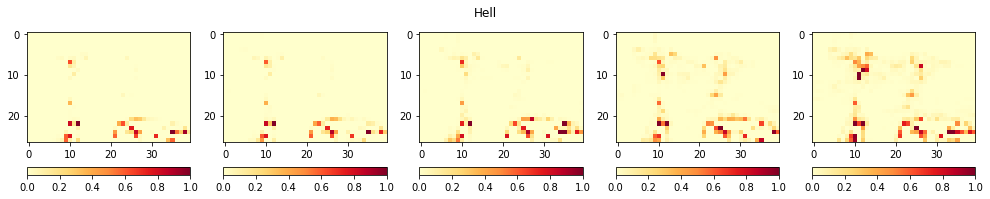

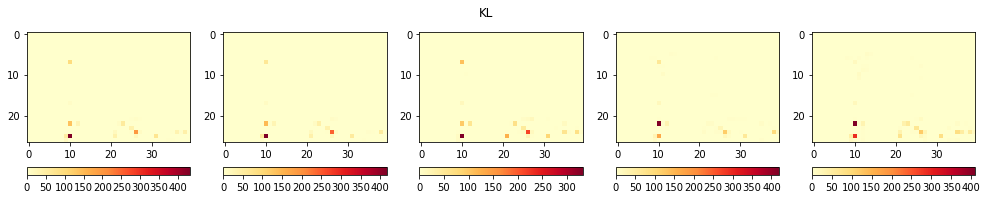

In [8]:
overall_start_time = time.time()

for metric in ["Hell", "KL"]:
    f, axarr = plt.subplots(1, len(compressed), figsize=(17, 3))
    f.suptitle(metric)
    
    for i in range(len(compressed)):
        print("Comparing original with compressed image #" + str(i))
        print("Metric:", metric)
        start_time = time.time()
        # dist = np.zeros((2,2)) # debug
        dist = computeDistance(compressed[i], original, 15, metric)
        diff_time = round(time.time() - start_time, 2)
        print("Distance:", np.sum(dist))
        print("Running time:", str(diff_time) + "s")
        print()
        a = axarr[i].imshow(dist, cmap="YlOrRd")
        f.colorbar(a, ax=axarr[i], orientation='horizontal')
    
print("Total running time: ", str(round(time.time() - overall_start_time, 2)) + "s")